In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import malaya_speech

2022-09-05 00:09:17.281408: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/home/ubuntu/tf-nvidia/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = malaya_speech.tts.tacotron2(model = 'female-singlish')

To get better speech synthesis, make sure Malaya version >= 4.9
2022-09-05 00:09:24.066237: I tensorflow/core/platform/profile_utils/cpu_utils.cc:109] CPU Frequency: 2496000000 Hz
2022-09-05 00:09:24.067121: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x80f52c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-05 00:09:24.067155: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-05 00:09:24.069418: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-05 00:09:24.172267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 00:09:24.173062: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8087210 initialized for platform CUDA (this does 

In [4]:
from glob import glob
import numpy as np

files = glob('../speech-bahasa/output-female-singlish/mels/*.npy')
len(files)

6016

In [5]:
f = files[0]
text_ids = np.load(f.replace('mels', 'text_ids'), allow_pickle=True)[
    0
]
text_ids

'my right foot feels like that of a chinese debutante .'

In [6]:
import re

pad_to = 8
_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
_rejected = '\'():;"'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [7]:
text_ids = ''.join(
    [
        c
        for c in text_ids
        if c in MALAYA_SPEECH_SYMBOLS and c not in _rejected
    ]
)
text_ids = re.sub(r'[ ]+', ' ', text_ids).strip()
text_input = np.array(
    [MALAYA_SPEECH_SYMBOLS.index(c) for c in text_ids]
)
num_pad = pad_to - ((len(text_input) + 2) % pad_to)
text_input = np.pad(
    text_input, ((1, 1)), 'constant', constant_values=((1, 2))
)
text_input = np.pad(
    text_input, ((0, num_pad)), 'constant', constant_values=0
)

In [8]:
class N:
    def normalize(self, text_ids):
        text_ids = ''.join(
            [
                c
                for c in text_ids
                if c in MALAYA_SPEECH_SYMBOLS and c not in _rejected
            ]
        )
        text_ids = re.sub(r'[ ]+', ' ', text_ids).strip()
        text_input = np.array(
            [MALAYA_SPEECH_SYMBOLS.index(c) for c in text_ids]
        )
        num_pad = pad_to - ((len(text_input) + 2) % pad_to)
        text_input = np.pad(
            text_input, ((1, 1)), 'constant', constant_values=((1, 2))
        )
        text_input = np.pad(
            text_input, ((0, num_pad)), 'constant', constant_values=0
        )
        return text_ids, text_input

In [9]:
n = N()

In [10]:
n.normalize('saya')

('saya', array([ 1, 58, 40, 64, 40,  2,  0,  0]))

In [11]:
model._normalizer = n

In [12]:
r = model.predict(text_ids)
alignment = r['alignment']

2022-09-05 00:09:26.433866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-05 00:09:27.291491: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


In [13]:
alignment.shape

(64, 259)

In [14]:
import matplotlib.pyplot as plt

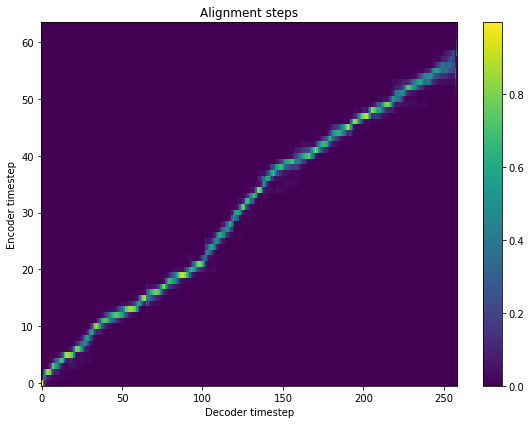

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    alignment,
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [16]:
vocoder = malaya_speech.vocoder.melgan()

2022-09-05 00:09:32.641771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 00:09:32.643423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.725
pciBusID: 0000:01:00.0
2022-09-05 00:09:32.643449: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-05 00:09:32.643482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-05 00:09:32.643499: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-09-05 00:09:32.643512: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library l

In [17]:
y_ = vocoder.predict([r['universal-output']])
y_.shape

(1, 66304)

In [18]:
import IPython.display as ipd

In [19]:
ipd.Audio(y_[0],rate = 22050)

In [20]:
def get_duration_from_alignment(alignment):
    D = np.array([0 for _ in range(np.shape(alignment)[0])])

    for i in range(np.shape(alignment)[1]):
        max_index = list(alignment[:, i]).index(alignment[:, i].max())
        D[max_index] = D[max_index] + 1

    return D

In [21]:
d = get_duration_from_alignment(alignment)
d.sum()

259

In [22]:
len(r['universal-output'])

259

In [23]:
directory = 'tacotron2-female-singlish-alignment'
os.system(f'rm -rf {directory}')
os.system(f'mkdir {directory}')

0

In [24]:
file = f.split('/')[-1]
file = f'{directory}/{file}'
len_mel = len(r['universal-output'])
d = get_duration_from_alignment(alignment)
assert d.sum() == len_mel
np.save(file, d)

In [25]:
from tqdm import tqdm

for f in tqdm(files):
    file = f.split('/')[-1]
    file = f'{directory}/{file}'
    text_ids = np.load(f.replace('mels', 'text_ids'), allow_pickle=True)[
        0
    ]
    r = model.predict(text_ids)
    alignment = r['alignment']
    len_mel = len(r['universal-output'])
    d = get_duration_from_alignment(alignment)
    assert d.sum() == len_mel
    np.save(file, d)

100%|███████████████████████████████████████████████████████████████████████████████████████| 6016/6016 [24:50<00:00,  4.04it/s]
